Using device: cpu
데이터 로드 완료. (총 2956일치 데이터)

월별 분할 완료:
Train indices: 2390, Val indices: 282, Test indices: 284

전체 시퀀스 생성 완료: (2926, 30, 4)

시퀀스 분할 완료:
X_train shape: (2366, 30, 4), y_train shape: (2366, 1)
X_val shape: (280, 30, 4), y_val shape: (280, 1)
X_test shape: (280, 30, 4), y_test shape: (280, 1)

DataLoader 생성 완료:
Train batches: 74, Validation batches: 9, Test batches: 9

--- RNN_PyTorch 모델 훈련 시작 ---
Epoch [10/150], Train Loss: 0.000678, Val Loss: 0.000253
Epoch [20/150], Train Loss: 0.000536, Val Loss: 0.000232
Epoch [30/150], Train Loss: 0.000508, Val Loss: 0.001208
Epoch [40/150], Train Loss: 0.000353, Val Loss: 0.000163
조기 종료: 49 Epoch에서 훈련 중단
--- RNN_PyTorch 모델 훈련 완료 ---

--- LSTM_PyTorch 모델 훈련 시작 ---
Epoch [10/150], Train Loss: 0.000869, Val Loss: 0.000833
Epoch [20/150], Train Loss: 0.000637, Val Loss: 0.000759
Epoch [30/150], Train Loss: 0.000596, Val Loss: 0.000464
Epoch [40/150], Train Loss: 0.000483, Val Loss: 0.000789
Epoch [50/150], Train Loss: 0.000424, Val Los

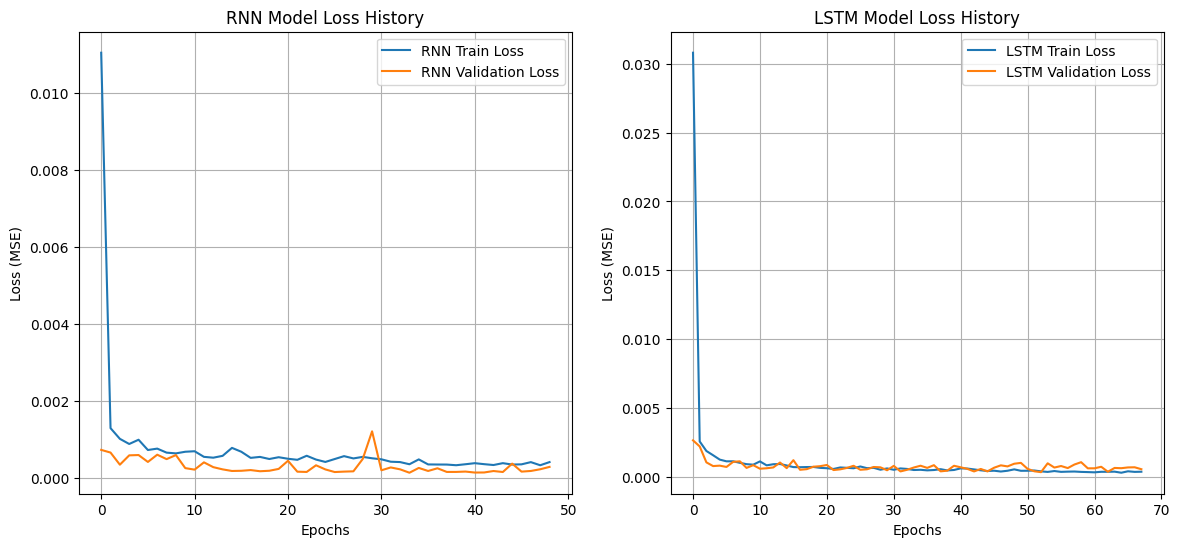


--- 최종 모델 평가 (RMSE) ---
PyTorch SimpleRNN 모델 RMSE: 13.8886
PyTorch LSTM 모델 RMSE: 18.2059


/tmp/ipython-input-3758996918.py:364: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  plt.savefig(plot_filename)
/tmp/ipython-input-3758996918.py:364: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  plt.savefig(plot_filename)
/tmp/ipython-input-3758996918.py:364: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.savefig(plot_filename)
/tmp/ipython-input-3758996918.py:364: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  plt.savefig(plot_filename)
/tmp/ipython-input-3758996918.py:364: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.savefig(plot_filename)
/tmp/ipython-input-3758996918.py:364: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  plt.savefig(plot_filename)
/tmp/ipython-input-3758996918.py:364: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) m


결과 그래프가 /content/tesla_prediction_pytorch_comparison.png 파일로 저장되었습니다.


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/loc

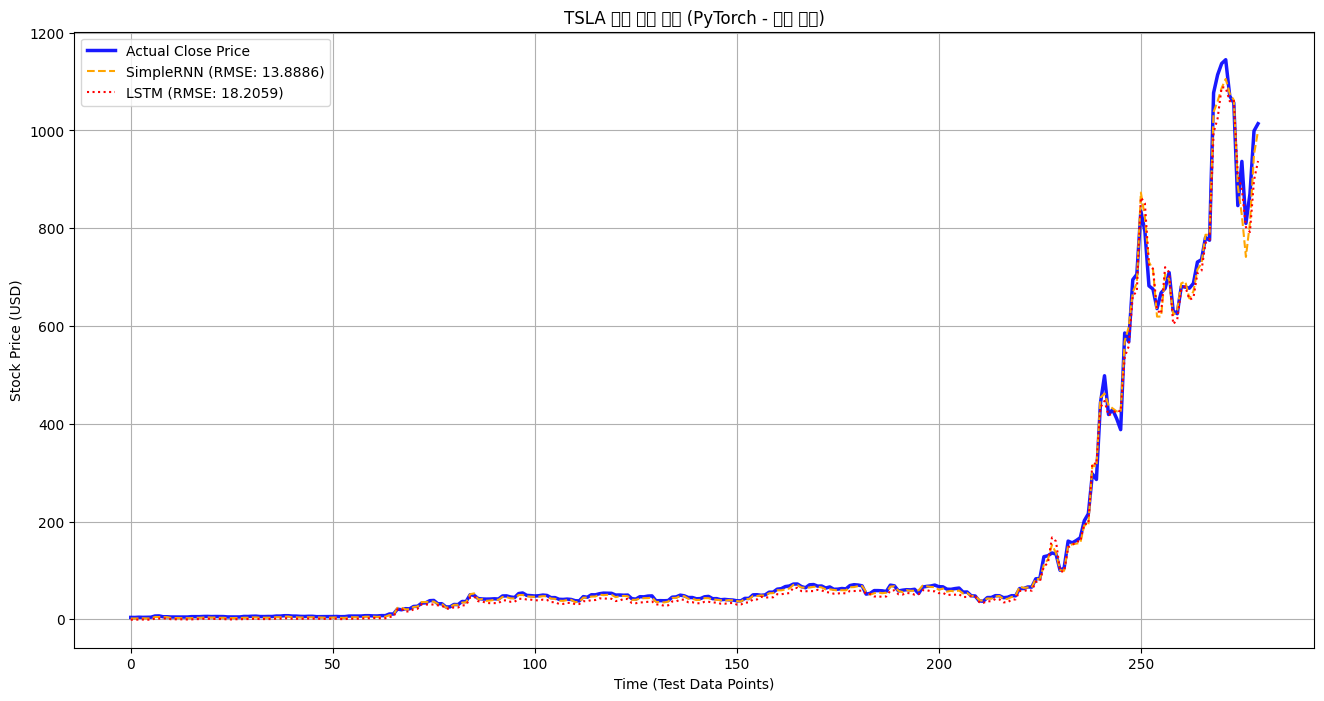

In [4]:
# -*- coding: utf-8 -*-
# --- 0. 라이브러리 임포트 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Subset

# 재현성을 위한 시드 설정
np.random.seed(42)
torch.manual_seed(42)

# --- 1. 하이퍼파라미터 및 데이터 로드 ---
WINDOW_SIZE = 30
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 150
PATIENCE = 15
WEIGHT_DECAY = 1e-5   # L2 정규화 (과적합 방지)
file_path = '/content/drive/MyDrive/Colab Notebooks/TSLA.csv'

# 데이터 로드
try:
    df = pd.read_csv(file_path, parse_dates=['Date'])
    df = df.sort_values("Date").reset_index(drop=True)
except FileNotFoundError:
    print(f"오류: '{file_path}'를 찾을 수 없습니다.")
    print("Colab 런타임의 '/content/' 경로에 TSLA.csv 파일을 업로드했는지 확인하세요.")
    # Colab에서 실행 중지
    exit()

# 사용할 피처 선택 (Volume 추가)
features_df = df[['Open', 'High', 'Low', 'Volume']]
target_df = df[['Close']]
dates_sr = df['Date']

print(f"데이터 로드 완료. (총 {len(df)}일치 데이터)")


# --- 2. 데이터 분할 ---

def calendar_split_indices(dates, val_days=2, test_days=2):
    """
    날짜를 기준으로 월별 훈련/검증/테스트 인덱스를 분리
    """
    date_series = pd.Series(dates)
    grouped = date_series.groupby([date_series.dt.year, date_series.dt.month], sort=True)

    train_idx, val_idx, test_idx = [], [], []
    for _, month_indices in grouped.groups.items():
        idx_sorted = np.sort(month_indices)
        n = len(idx_sorted)
        if n == 0: continue

        test_count = min(test_days, n)
        remaining = n - test_count
        val_count = min(val_days, remaining)
        train_count = max(remaining - val_count, 0)

        if train_count > 0:
            train_idx.extend(idx_sorted[:train_count])
        if val_count > 0:
            val_start = train_count
            val_idx.extend(idx_sorted[val_start : val_start + val_count])
        if test_count > 0:
            test_idx.extend(idx_sorted[-test_count:])

    return (
        np.array(sorted(train_idx), dtype=int),
        np.array(sorted(val_idx), dtype=int),
        np.array(sorted(test_idx), dtype=int),
    )

# 매월 마지막 2일은 테스트, 그 앞 2일은 검증, 나머지는 훈련
train_idx, val_idx, test_idx = calendar_split_indices(df['Date'], val_days=2, test_days=2)

print(f"\n월별 분할 완료:")
print(f"Train indices: {len(train_idx)}, Val indices: {len(val_idx)}, Test indices: {len(test_idx)}")
#

# --- 3. 정규화 (Data Leakage 방지) ---

# 3-1. 스케일러 '학습(fit)' (훈련 인덱스로만!)
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

#
feature_scaler.fit(features_df.iloc[train_idx])
target_scaler.fit(target_df.iloc[train_idx])

# 3-2. 데이터 '변환(transform)'
scaled_features = feature_scaler.transform(features_df)
scaled_target = target_scaler.transform(target_df)


# --- 4. 윈도우 시퀀스 생성 ---

def create_sequences(features, target, window_size):
    X, y = [], []
    # -1을 하여 마지막 window_size에서도 target을 가져올 수 있도록 함
    for i in range(len(features) - window_size):
        X.append(features[i:(i + window_size)])
        y.append(target[i + window_size])
    return np.array(X), np.array(y)

# 전체 데이터에 대해 시퀀스 생성
all_X, all_y = create_sequences(scaled_features, scaled_target, WINDOW_SIZE)
# 시퀀스는 window_size일 이후부터 시작하므로 인덱스 조정
all_indices = np.arange(WINDOW_SIZE, len(scaled_features))

print(f"\n전체 시퀀스 생성 완료: {all_X.shape}")

# --- 5. PyTorch Tensors 및 DataLoader 생성 ---

# 5-1. 시퀀스 인덱스를 기준으로 훈련/검증/테스트 분리
# (시퀀스 생성으로 인해 all_indices가 train_idx 등 보다 작으므로, train_idx가 all_indices에 포함되는지 확인)
train_mask = np.isin(all_indices, train_idx)
val_mask = np.isin(all_indices, val_idx)
test_mask = np.isin(all_indices, test_idx)

X_train, y_train = all_X[train_mask], all_y[train_mask]
X_val, y_val = all_X[val_mask], all_y[val_mask]
X_test, y_test = all_X[test_mask], all_y[test_mask]

print(f"\n시퀀스 분할 완료:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# 5-2. Tensors 생성
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# 5-3. DataLoader 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nDataLoader 생성 완료:")
print(f"Train batches: {len(train_loader)}, Validation batches: {len(val_loader)}, Test batches: {len(test_loader)}")


# --- 6. PyTorch 모델 정의 ---
# 모델 파라미터
INPUT_SIZE = X_train.shape[2] # 4 (O, H, L, V)
HIDDEN_SIZE_1 = 64
HIDDEN_SIZE_2 = 32
DENSE_SIZE = 16
OUTPUT_SIZE = 1
DROPOUT_PROB = 0.2

#
# 6-1. SimpleRNN 모델
class SimpleRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, dense_size, output_size, dropout_prob):
        super(SimpleRNNModel, self).__init__()
        self.rnn1 = nn.RNN(input_size, hidden_size1, batch_first=True)
        self.rnn2 = nn.RNN(hidden_size1, hidden_size2, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_size2, dense_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(dense_size, output_size)

    def forward(self, x):
        out, _ = self.rnn1(x)
        out, _ = self.rnn2(out)
        out = self.dropout(out)
        out = out[:, -1, :] # 마지막 타임스텝의 출력만 사용
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# 6-2. LSTM 모델
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, dense_size, output_size, dropout_prob):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_size2, dense_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(dense_size, output_size)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out = self.dropout(out)
        out = out[:, -1, :] # 마지막 타임스텝의 출력만 사용
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out


# --- 7. 훈련 루프 정의 ---
def train_model(model, model_name):
    print(f"\n--- {model_name} 모델 훈련 시작 ---")
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(NUM_EPOCHS):
        model.train()
        epoch_train_loss = 0
        for seqs, labels in train_loader:
            seqs, labels = seqs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(seqs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for seqs, labels in val_loader: # 올바른 검증 로더 사용
                seqs, labels = seqs.to(device), labels.to(device)
                outputs = model(seqs)
                loss = criterion(outputs, labels)
                epoch_val_loss += loss.item()

        avg_train_loss = epoch_train_loss / len(train_loader)
        avg_val_loss = epoch_val_loss / len(val_loader)
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"{model_name}_best.pth")
        else:
            patience_counter += 1

        if patience_counter >= PATIENCE:
            print(f"조기 종료: {epoch+1} Epoch에서 훈련 중단")
            break

    print(f"--- {model_name} 모델 훈련 완료 ---")

    # 가장 성능이 좋았던 모델 가중치 로드
    model.load_state_dict(torch.load(f"{model_name}_best.pth"))

    return model, history

# --- 8. 모델 훈련 및 평가 ---
results = {}

# 8-1. RNN 훈련 및 평가
rnn_model_pt = SimpleRNNModel(INPUT_SIZE, HIDDEN_SIZE_1, HIDDEN_SIZE_2, DENSE_SIZE, OUTPUT_SIZE, DROPOUT_PROB).to(device)
rnn_model_pt, rnn_history = train_model(rnn_model_pt, "RNN_PyTorch")

# 8-2. LSTM 훈련 및 평가
lstm_model_pt = LSTMModel(INPUT_SIZE, HIDDEN_SIZE_1, HIDDEN_SIZE_2, DENSE_SIZE, OUTPUT_SIZE, DROPOUT_PROB).to(device)
lstm_model_pt, lstm_history = train_model(lstm_model_pt, "LSTM_PyTorch")


# --- 9. 훈련 과정 시각화 ---
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(rnn_history['train_loss'], label='RNN Train Loss')
plt.plot(rnn_history['val_loss'], label='RNN Validation Loss')
plt.title('RNN Model Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(lstm_history['train_loss'], label='LSTM Train Loss')
plt.plot(lstm_history['val_loss'], label='LSTM Validation Loss')
plt.title('LSTM Model Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


# --- 10. 최종 예측 및 결과 비교 ---

def evaluate_model(model, X_test, y_test, scaler):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)

    # CPU로 데이터 이동 후 NumPy 배열로 변환
    predictions_np = predictions.cpu().numpy()
    y_test_np = y_test.cpu().numpy()

    # 역정규화
    inv_predictions = scaler.inverse_transform(predictions_np)
    inv_y_test = scaler.inverse_transform(y_test_np)

    rmse = np.sqrt(mean_squared_error(inv_y_test, inv_predictions))
    return rmse, inv_predictions, inv_y_test

rnn_rmse, rnn_preds, rnn_actuals = evaluate_model(rnn_model_pt, X_test_tensor, y_test_tensor, target_scaler)
lstm_rmse, lstm_preds, lstm_actuals = evaluate_model(lstm_model_pt, X_test_tensor, y_test_tensor, target_scaler)

print(f"\n--- 최종 모델 평가 (RMSE) ---")
print(f"PyTorch SimpleRNN 모델 RMSE: {rnn_rmse:.4f}")
print(f"PyTorch LSTM 모델 RMSE: {lstm_rmse:.4f}")

# --- 11. 최종 결과 시각화 ---
plt.figure(figsize=(16, 8))
plt.title(f'TSLA 주가 예측 비교 (PyTorch - 월별 분할)')
plt.xlabel('Time (Test Data Points)')
plt.ylabel('Stock Price (USD)')

# 월별 분할로 인해 테스트 데이터가 드문드문 있으므로, x축을 시간 대신 인덱스로 표시
test_index = np.arange(len(rnn_actuals))

plt.plot(test_index, rnn_actuals, label='Actual Close Price', color='blue', alpha=0.9, linewidth=2.5)
plt.plot(test_index, rnn_preds, label=f'SimpleRNN (RMSE: {rnn_rmse:.4f})', color='orange', linestyle='--')
plt.plot(test_index, lstm_preds, label=f'LSTM (RMSE: {lstm_rmse:.4f})', color='red', linestyle=':')
plt.legend()
plt.grid(True)

plot_filename = '/content/tesla_prediction_pytorch_comparison.png'
plt.savefig(plot_filename)
print(f"\n결과 그래프가 {plot_filename} 파일로 저장되었습니다.")
plt.show()